## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2020-06-06 18:16:08--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.165.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.165.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  83.6MB/s    in 4.1s    

2020-06-06 18:16:12 (78.3 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_

  inflating: /data/test/Baburam_Bhattari_31.jpg  
  inflating: /data/test/Barbara_Bodine_00.jpg  
  inflating: /data/test/Barbara_Bodine_01.jpg  
  inflating: /data/test/Barbara_Bodine_20.jpg  
  inflating: /data/test/Barbara_Bodine_21.jpg  
  inflating: /data/test/Barbara_Bodine_40.jpg  
  inflating: /data/test/Barbara_Bodine_41.jpg  
  inflating: /data/test/Barbara_Bodine_50.jpg  
  inflating: /data/test/Barbara_Bodine_51.jpg  
  inflating: /data/test/Barbara_Boxer_10.jpg  
  inflating: /data/test/Barbara_Boxer_11.jpg  
  inflating: /data/test/Barbara_Boxer_40.jpg  
  inflating: /data/test/Barbara_Boxer_41.jpg  
  inflating: /data/test/Barbara_Boxer_50.jpg  
  inflating: /data/test/Barbara_Boxer_51.jpg  
  inflating: /data/test/Barbara_Walters_00.jpg  
  inflating: /data/test/Barbara_Walters_01.jpg  
  inflating: /data/test/Barbara_Walters_20.jpg  
  inflating: /data/test/Barbara_Walters_21.jpg  
  inflating: /data/test/Barbara_Walters_40.jpg  
  inflating: /data/test/Barbara_Walters

  inflating: /data/test/Cherie_Blair_31.jpg  
  inflating: /data/test/Cherie_Blair_40.jpg  
  inflating: /data/test/Cherie_Blair_41.jpg  
  inflating: /data/test/Chita_Rivera_00.jpg  
  inflating: /data/test/Chita_Rivera_01.jpg  
  inflating: /data/test/Chita_Rivera_10.jpg  
  inflating: /data/test/Chita_Rivera_11.jpg  
  inflating: /data/test/Chita_Rivera_30.jpg  
  inflating: /data/test/Chita_Rivera_31.jpg  
  inflating: /data/test/Chris_Cirino_20.jpg  
  inflating: /data/test/Chris_Cirino_21.jpg  
  inflating: /data/test/Chris_Cirino_30.jpg  
  inflating: /data/test/Chris_Cirino_31.jpg  
  inflating: /data/test/Chris_Cirino_50.jpg  
  inflating: /data/test/Chris_Cirino_51.jpg  
  inflating: /data/test/Chris_Cooper_00.jpg  
  inflating: /data/test/Chris_Cooper_01.jpg  
  inflating: /data/test/Chris_Cooper_30.jpg  
  inflating: /data/test/Chris_Cooper_31.jpg  
  inflating: /data/test/Chris_Cooper_40.jpg  
  inflating: /data/test/Chris_Cooper_41.jpg  
  inflating: /data/test/Chris_Matt

  inflating: /data/test/Dai_Bachtiar_10.jpg  
  inflating: /data/test/Dai_Bachtiar_11.jpg  
  inflating: /data/test/Dai_Bachtiar_20.jpg  
  inflating: /data/test/Dai_Bachtiar_21.jpg  
  inflating: /data/test/Dai_Bachtiar_50.jpg  
  inflating: /data/test/Dai_Bachtiar_51.jpg  
  inflating: /data/test/Daisy_Fuentes_20.jpg  
  inflating: /data/test/Daisy_Fuentes_21.jpg  
  inflating: /data/test/Daisy_Fuentes_30.jpg  
  inflating: /data/test/Daisy_Fuentes_31.jpg  
  inflating: /data/test/Daisy_Fuentes_40.jpg  
  inflating: /data/test/Daisy_Fuentes_41.jpg  
  inflating: /data/test/Dan_Ackroyd_00.jpg  
  inflating: /data/test/Dan_Ackroyd_01.jpg  
  inflating: /data/test/Dan_Ackroyd_20.jpg  
  inflating: /data/test/Dan_Ackroyd_21.jpg  
  inflating: /data/test/Dan_Ackroyd_30.jpg  
  inflating: /data/test/Dan_Ackroyd_31.jpg  
  inflating: /data/test/Daniel_Radcliffe_00.jpg  
  inflating: /data/test/Daniel_Radcliffe_01.jpg  
  inflating: /data/test/Daniel_Radcliffe_20.jpg  
  inflating: /data/tes

  inflating: /data/test/Eric_Benet_01.jpg  
  inflating: /data/test/Eric_Benet_10.jpg  
  inflating: /data/test/Eric_Benet_11.jpg  
  inflating: /data/test/Eric_Benet_30.jpg  
  inflating: /data/test/Eric_Benet_31.jpg  
  inflating: /data/test/Erin_Hershey_Presley_10.jpg  
  inflating: /data/test/Erin_Hershey_Presley_11.jpg  
  inflating: /data/test/Erin_Hershey_Presley_30.jpg  
  inflating: /data/test/Erin_Hershey_Presley_31.jpg  
  inflating: /data/test/Erin_Hershey_Presley_40.jpg  
  inflating: /data/test/Erin_Hershey_Presley_41.jpg  
  inflating: /data/test/Ernest_Hollings_00.jpg  
  inflating: /data/test/Ernest_Hollings_01.jpg  
  inflating: /data/test/Ernest_Hollings_10.jpg  
  inflating: /data/test/Ernest_Hollings_11.jpg  
  inflating: /data/test/Ernest_Hollings_20.jpg  
  inflating: /data/test/Ernest_Hollings_21.jpg  
  inflating: /data/test/Ernesto_Zedillo_10.jpg  
  inflating: /data/test/Ernesto_Zedillo_11.jpg  
  inflating: /data/test/Ernesto_Zedillo_20.jpg  
  inflating: /d

  inflating: /data/test/Irene_Kahn_00.jpg  
  inflating: /data/test/Irene_Kahn_01.jpg  
  inflating: /data/test/Irene_Kahn_30.jpg  
  inflating: /data/test/Irene_Kahn_31.jpg  
  inflating: /data/test/Irene_Kahn_40.jpg  
  inflating: /data/test/Irene_Kahn_41.jpg  
  inflating: /data/test/Isabella_Rossellini_00.jpg  
  inflating: /data/test/Isabella_Rossellini_01.jpg  
  inflating: /data/test/Isabella_Rossellini_10.jpg  
  inflating: /data/test/Isabella_Rossellini_11.jpg  
  inflating: /data/test/Isabella_Rossellini_20.jpg  
  inflating: /data/test/Isabella_Rossellini_21.jpg  
  inflating: /data/test/Isabelle_Huppert_20.jpg  
  inflating: /data/test/Isabelle_Huppert_21.jpg  
  inflating: /data/test/Isabelle_Huppert_30.jpg  
  inflating: /data/test/Isabelle_Huppert_31.jpg  
  inflating: /data/test/Isabelle_Huppert_40.jpg  
  inflating: /data/test/Isabelle_Huppert_41.jpg  
  inflating: /data/test/Itzhak_Perlman_10.jpg  
  inflating: /data/test/Itzhak_Perlman_11.jpg  
  inflating: /data/tes

  inflating: /data/test/Kirk_Ferentz_51.jpg  
  inflating: /data/test/Kirsten_Dunst_00.jpg  
  inflating: /data/test/Kirsten_Dunst_01.jpg  
  inflating: /data/test/Kirsten_Dunst_20.jpg  
  inflating: /data/test/Kirsten_Dunst_21.jpg  
  inflating: /data/test/Kirsten_Dunst_30.jpg  
  inflating: /data/test/Kirsten_Dunst_31.jpg  
  inflating: /data/test/Kit_Bond_10.jpg  
  inflating: /data/test/Kit_Bond_11.jpg  
  inflating: /data/test/Kit_Bond_20.jpg  
  inflating: /data/test/Kit_Bond_21.jpg  
  inflating: /data/test/Kit_Bond_30.jpg  
  inflating: /data/test/Kit_Bond_31.jpg  
  inflating: /data/test/Kit_Bond_50.jpg  
  inflating: /data/test/Kit_Bond_51.jpg  
  inflating: /data/test/Kristen_Breitweiser_00.jpg  
  inflating: /data/test/Kristen_Breitweiser_01.jpg  
  inflating: /data/test/Kristen_Breitweiser_10.jpg  
  inflating: /data/test/Kristen_Breitweiser_11.jpg  
  inflating: /data/test/Kristen_Breitweiser_20.jpg  
  inflating: /data/test/Kristen_Breitweiser_21.jpg  
  inflating: /data

  inflating: /data/test/Luc_Montagnier_50.jpg  
  inflating: /data/test/Luc_Montagnier_51.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_00.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_01.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_10.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_11.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_40.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_41.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_50.jpg  
  inflating: /data/test/Lucia_Kenny_Anthony_51.jpg  
  inflating: /data/test/Lucio_Stanca_00.jpg  
  inflating: /data/test/Lucio_Stanca_01.jpg  
  inflating: /data/test/Lucio_Stanca_20.jpg  
  inflating: /data/test/Lucio_Stanca_21.jpg  
  inflating: /data/test/Lucio_Stanca_30.jpg  
  inflating: /data/test/Lucio_Stanca_31.jpg  
  inflating: /data/test/Lucio_Stanca_40.jpg  
  inflating: /data/test/Lucio_Stanca_41.jpg  
  inflating: /data/test/Luis_Ernesto_Derbez_Bautista_00.jpg  
  inflating: /data/test/Luis_Ernesto_Derbez_Bautis

  inflating: /data/test/Martin_Sheen_51.jpg  
  inflating: /data/test/Mary_Landrieu_00.jpg  
  inflating: /data/test/Mary_Landrieu_01.jpg  
  inflating: /data/test/Mary_Landrieu_20.jpg  
  inflating: /data/test/Mary_Landrieu_21.jpg  
  inflating: /data/test/Mary_Landrieu_30.jpg  
  inflating: /data/test/Mary_Landrieu_31.jpg  
  inflating: /data/test/Mary_Robinson_10.jpg  
  inflating: /data/test/Mary_Robinson_11.jpg  
  inflating: /data/test/Mary_Robinson_20.jpg  
  inflating: /data/test/Mary_Robinson_21.jpg  
  inflating: /data/test/Mary_Robinson_40.jpg  
  inflating: /data/test/Mary_Robinson_41.jpg  
  inflating: /data/test/Mary_Robinson_50.jpg  
  inflating: /data/test/Mary_Robinson_51.jpg  
  inflating: /data/test/Massoud_Barzani_00.jpg  
  inflating: /data/test/Massoud_Barzani_01.jpg  
  inflating: /data/test/Massoud_Barzani_10.jpg  
  inflating: /data/test/Massoud_Barzani_11.jpg  
  inflating: /data/test/Massoud_Barzani_20.jpg  
  inflating: /data/test/Massoud_Barzani_21.jpg  
  

  inflating: /data/test/Prince_Harry_10.jpg  
  inflating: /data/test/Prince_Harry_11.jpg  
  inflating: /data/test/Prince_Harry_20.jpg  
  inflating: /data/test/Prince_Harry_21.jpg  
  inflating: /data/test/Prince_Harry_40.jpg  
  inflating: /data/test/Prince_Harry_41.jpg  
  inflating: /data/test/Princess_Stephanie_00.jpg  
  inflating: /data/test/Princess_Stephanie_01.jpg  
  inflating: /data/test/Princess_Stephanie_20.jpg  
  inflating: /data/test/Princess_Stephanie_21.jpg  
  inflating: /data/test/Princess_Stephanie_40.jpg  
  inflating: /data/test/Princess_Stephanie_41.jpg  
  inflating: /data/test/Princess_Stephanie_50.jpg  
  inflating: /data/test/Princess_Stephanie_51.jpg  
  inflating: /data/test/Priyanka_Chopra_10.jpg  
  inflating: /data/test/Priyanka_Chopra_11.jpg  
  inflating: /data/test/Priyanka_Chopra_40.jpg  
  inflating: /data/test/Priyanka_Chopra_41.jpg  
  inflating: /data/test/Priyanka_Chopra_50.jpg  
  inflating: /data/test/Priyanka_Chopra_51.jpg  
  inflating: /

  inflating: /data/test/Teresa_Heinz_Kerry_21.jpg  
  inflating: /data/test/Terje_Roed-Larsen_00.jpg  
  inflating: /data/test/Terje_Roed-Larsen_01.jpg  
  inflating: /data/test/Terje_Roed-Larsen_20.jpg  
  inflating: /data/test/Terje_Roed-Larsen_21.jpg  
  inflating: /data/test/Terje_Roed-Larsen_30.jpg  
  inflating: /data/test/Terje_Roed-Larsen_31.jpg  
  inflating: /data/test/Tessa_Jowell_00.jpg  
  inflating: /data/test/Tessa_Jowell_01.jpg  
  inflating: /data/test/Tessa_Jowell_20.jpg  
  inflating: /data/test/Tessa_Jowell_21.jpg  
  inflating: /data/test/Tessa_Jowell_30.jpg  
  inflating: /data/test/Tessa_Jowell_31.jpg  
  inflating: /data/test/Tessa_Jowell_50.jpg  
  inflating: /data/test/Tessa_Jowell_51.jpg  
  inflating: /data/test/Thomas_Ferguson_00.jpg  
  inflating: /data/test/Thomas_Ferguson_01.jpg  
  inflating: /data/test/Thomas_Ferguson_10.jpg  
  inflating: /data/test/Thomas_Ferguson_11.jpg  
  inflating: /data/test/Thomas_Ferguson_50.jpg  
  inflating: /data/test/Thoma

  inflating: /data/test_frames_keypoints.csv  
   creating: /data/training/
  inflating: /data/training/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_02.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_12.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/training/Abdel_Aziz_Al-Hakim_42.jpg  
  inflating: /data/training/Abdullah_Gul_10.jpg  
  inflating: /data/training/Abdullah_Gul_11.jpg  
  inflating: /data/training/Abdullah_Gul_12.jpg  
  inflating: /data/training/Abdullah_Gul_30.jpg  
  inflating: /data/training/Abdullah_Gul_31.jpg  
  inflating: /data/training/Abdullah_Gul_32.jpg  
  inflating: /data/training/Abdullah_Gul_50.jpg  
  inflating: /data/training/Abdullah_Gul_51.jpg  
  inflating

  inflating: /data/training/Amelia_Vega_12.jpg  
  inflating: /data/training/Amelia_Vega_20.jpg  
  inflating: /data/training/Amelia_Vega_21.jpg  
  inflating: /data/training/Amelia_Vega_22.jpg  
  inflating: /data/training/Amelia_Vega_30.jpg  
  inflating: /data/training/Amelia_Vega_31.jpg  
  inflating: /data/training/Amelia_Vega_32.jpg  
  inflating: /data/training/Amelia_Vega_40.jpg  
  inflating: /data/training/Amelia_Vega_41.jpg  
  inflating: /data/training/Amelia_Vega_42.jpg  
  inflating: /data/training/Amy_Brenneman_10.jpg  
  inflating: /data/training/Amy_Brenneman_11.jpg  
  inflating: /data/training/Amy_Brenneman_12.jpg  
  inflating: /data/training/Amy_Brenneman_30.jpg  
  inflating: /data/training/Amy_Brenneman_31.jpg  
  inflating: /data/training/Amy_Brenneman_32.jpg  
  inflating: /data/training/Amy_Brenneman_50.jpg  
  inflating: /data/training/Amy_Brenneman_51.jpg  
  inflating: /data/training/Amy_Brenneman_52.jpg  
  inflating: /data/training/Andrea_Bocelli_10.jpg  

  inflating: /data/training/Biljana_Plavsic_12.jpg  
  inflating: /data/training/Biljana_Plavsic_30.jpg  
  inflating: /data/training/Biljana_Plavsic_31.jpg  
  inflating: /data/training/Biljana_Plavsic_32.jpg  
  inflating: /data/training/Bill_Bradley_10.jpg  
  inflating: /data/training/Bill_Bradley_11.jpg  
  inflating: /data/training/Bill_Bradley_12.jpg  
  inflating: /data/training/Bill_Bradley_30.jpg  
  inflating: /data/training/Bill_Bradley_31.jpg  
  inflating: /data/training/Bill_Bradley_32.jpg  
  inflating: /data/training/Bill_Bradley_50.jpg  
  inflating: /data/training/Bill_Bradley_51.jpg  
  inflating: /data/training/Bill_Bradley_52.jpg  
  inflating: /data/training/Bill_Clinton_00.jpg  
  inflating: /data/training/Bill_Clinton_01.jpg  
  inflating: /data/training/Bill_Clinton_02.jpg  
  inflating: /data/training/Bill_Clinton_10.jpg  
  inflating: /data/training/Bill_Clinton_11.jpg  
  inflating: /data/training/Bill_Clinton_12.jpg  
  inflating: /data/training/Bill_Clint

  inflating: /data/training/Chita_Rivera_12.jpg  
  inflating: /data/training/Chita_Rivera_30.jpg  
  inflating: /data/training/Chita_Rivera_31.jpg  
  inflating: /data/training/Chita_Rivera_32.jpg  
  inflating: /data/training/Chris_Cirino_20.jpg  
  inflating: /data/training/Chris_Cirino_21.jpg  
  inflating: /data/training/Chris_Cirino_22.jpg  
  inflating: /data/training/Chris_Cirino_30.jpg  
  inflating: /data/training/Chris_Cirino_31.jpg  
  inflating: /data/training/Chris_Cirino_32.jpg  
  inflating: /data/training/Chris_Cirino_50.jpg  
  inflating: /data/training/Chris_Cirino_51.jpg  
  inflating: /data/training/Chris_Cirino_52.jpg  
  inflating: /data/training/Chris_Cooper_00.jpg  
  inflating: /data/training/Chris_Cooper_01.jpg  
  inflating: /data/training/Chris_Cooper_02.jpg  
  inflating: /data/training/Chris_Cooper_30.jpg  
  inflating: /data/training/Chris_Cooper_31.jpg  
  inflating: /data/training/Chris_Cooper_32.jpg  
  inflating: /data/training/Chris_Cooper_40.jpg  


  inflating: /data/training/Connie_Chung_32.jpg  
  inflating: /data/training/Connie_Chung_40.jpg  
  inflating: /data/training/Connie_Chung_41.jpg  
  inflating: /data/training/Connie_Chung_42.jpg  
  inflating: /data/training/Connie_Chung_50.jpg  
  inflating: /data/training/Connie_Chung_51.jpg  
  inflating: /data/training/Connie_Chung_52.jpg  
  inflating: /data/training/Craig_David_10.jpg  
  inflating: /data/training/Craig_David_11.jpg  
  inflating: /data/training/Craig_David_12.jpg  
  inflating: /data/training/Craig_David_20.jpg  
  inflating: /data/training/Craig_David_21.jpg  
  inflating: /data/training/Craig_David_22.jpg  
  inflating: /data/training/Craig_David_30.jpg  
  inflating: /data/training/Craig_David_31.jpg  
  inflating: /data/training/Craig_David_32.jpg  
  inflating: /data/training/Craig_David_50.jpg  
  inflating: /data/training/Craig_David_51.jpg  
  inflating: /data/training/Craig_David_52.jpg  
  inflating: /data/training/Cristina_Fernandez_30.jpg  
  infl

  inflating: /data/training/Elaine_Stritch_11.jpg  
  inflating: /data/training/Elaine_Stritch_12.jpg  
  inflating: /data/training/Elaine_Stritch_40.jpg  
  inflating: /data/training/Elaine_Stritch_41.jpg  
  inflating: /data/training/Elaine_Stritch_42.jpg  
  inflating: /data/training/Elaine_Stritch_50.jpg  
  inflating: /data/training/Elaine_Stritch_51.jpg  
  inflating: /data/training/Elaine_Stritch_52.jpg  
  inflating: /data/training/Eliane_Karp_00.jpg  
  inflating: /data/training/Eliane_Karp_01.jpg  
  inflating: /data/training/Eliane_Karp_02.jpg  
  inflating: /data/training/Eliane_Karp_10.jpg  
  inflating: /data/training/Eliane_Karp_11.jpg  
  inflating: /data/training/Eliane_Karp_12.jpg  
  inflating: /data/training/Eliane_Karp_30.jpg  
  inflating: /data/training/Eliane_Karp_31.jpg  
  inflating: /data/training/Eliane_Karp_32.jpg  
  inflating: /data/training/Eliane_Karp_40.jpg  
  inflating: /data/training/Eliane_Karp_41.jpg  
  inflating: /data/training/Eliane_Karp_42.jp

  inflating: /data/training/Eunice_Barber_00.jpg  
  inflating: /data/training/Eunice_Barber_01.jpg  
  inflating: /data/training/Eunice_Barber_02.jpg  
  inflating: /data/training/Eunice_Barber_10.jpg  
  inflating: /data/training/Eunice_Barber_11.jpg  
  inflating: /data/training/Eunice_Barber_12.jpg  
  inflating: /data/training/Eunice_Barber_50.jpg  
  inflating: /data/training/Eunice_Barber_51.jpg  
  inflating: /data/training/Eunice_Barber_52.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_00.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_01.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_02.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_20.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_21.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_22.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_30.jpg  
  inflating: /data/training/Fernando_Henrique_Cardoso_31.jpg  
  inflating: /data/training/Fernando_

  inflating: /data/training/George_Karl_22.jpg  
  inflating: /data/training/George_Karl_50.jpg  
  inflating: /data/training/George_Karl_51.jpg  
  inflating: /data/training/George_Karl_52.jpg  
  inflating: /data/training/GL_Peiris_00.jpg  
  inflating: /data/training/GL_Peiris_01.jpg  
  inflating: /data/training/GL_Peiris_02.jpg  
  inflating: /data/training/GL_Peiris_10.jpg  
  inflating: /data/training/GL_Peiris_11.jpg  
  inflating: /data/training/GL_Peiris_12.jpg  
  inflating: /data/training/GL_Peiris_30.jpg  
  inflating: /data/training/GL_Peiris_31.jpg  
  inflating: /data/training/GL_Peiris_32.jpg  
  inflating: /data/training/Hanan_Ashrawi_10.jpg  
  inflating: /data/training/Hanan_Ashrawi_11.jpg  
  inflating: /data/training/Hanan_Ashrawi_12.jpg  
  inflating: /data/training/Hanan_Ashrawi_20.jpg  
  inflating: /data/training/Hanan_Ashrawi_21.jpg  
  inflating: /data/training/Hanan_Ashrawi_22.jpg  
  inflating: /data/training/Hanan_Ashrawi_40.jpg  
  inflating: /data/train

  inflating: /data/training/James_Cunningham_30.jpg  
  inflating: /data/training/James_Cunningham_31.jpg  
  inflating: /data/training/James_Cunningham_32.jpg  
  inflating: /data/training/James_Cunningham_40.jpg  
  inflating: /data/training/James_Cunningham_41.jpg  
  inflating: /data/training/James_Cunningham_42.jpg  
  inflating: /data/training/James_Hoffa_10.jpg  
  inflating: /data/training/James_Hoffa_11.jpg  
  inflating: /data/training/James_Hoffa_12.jpg  
  inflating: /data/training/James_Hoffa_20.jpg  
  inflating: /data/training/James_Hoffa_21.jpg  
  inflating: /data/training/James_Hoffa_22.jpg  
  inflating: /data/training/James_Hoffa_40.jpg  
  inflating: /data/training/James_Hoffa_41.jpg  
  inflating: /data/training/James_Hoffa_42.jpg  
  inflating: /data/training/James_Hoffa_50.jpg  
  inflating: /data/training/James_Hoffa_51.jpg  
  inflating: /data/training/James_Hoffa_52.jpg  
  inflating: /data/training/James_Lockhart_00.jpg  
  inflating: /data/training/James_Lo

  inflating: /data/training/Kirk_Ferentz_52.jpg  
  inflating: /data/training/Kirsten_Dunst_00.jpg  
  inflating: /data/training/Kirsten_Dunst_01.jpg  
  inflating: /data/training/Kirsten_Dunst_02.jpg  
  inflating: /data/training/Kirsten_Dunst_20.jpg  
  inflating: /data/training/Kirsten_Dunst_21.jpg  
  inflating: /data/training/Kirsten_Dunst_22.jpg  
  inflating: /data/training/Kirsten_Dunst_30.jpg  
  inflating: /data/training/Kirsten_Dunst_31.jpg  
  inflating: /data/training/Kirsten_Dunst_32.jpg  
  inflating: /data/training/Kit_Bond_10.jpg  
  inflating: /data/training/Kit_Bond_11.jpg  
  inflating: /data/training/Kit_Bond_12.jpg  
  inflating: /data/training/Kit_Bond_20.jpg  
  inflating: /data/training/Kit_Bond_21.jpg  
  inflating: /data/training/Kit_Bond_22.jpg  
  inflating: /data/training/Kit_Bond_30.jpg  
  inflating: /data/training/Kit_Bond_31.jpg  
  inflating: /data/training/Kit_Bond_32.jpg  
  inflating: /data/training/Kit_Bond_50.jpg  
  inflating: /data/training/Kit

  inflating: /data/training/Li_Zhaoxing_42.jpg  
  inflating: /data/training/Lincoln_Chafee_20.jpg  
  inflating: /data/training/Lincoln_Chafee_21.jpg  
  inflating: /data/training/Lincoln_Chafee_22.jpg  
  inflating: /data/training/Lincoln_Chafee_30.jpg  
  inflating: /data/training/Lincoln_Chafee_31.jpg  
  inflating: /data/training/Lincoln_Chafee_32.jpg  
  inflating: /data/training/Lincoln_Chafee_50.jpg  
  inflating: /data/training/Lincoln_Chafee_51.jpg  
  inflating: /data/training/Lincoln_Chafee_52.jpg  
  inflating: /data/training/Linda_Dano_00.jpg  
  inflating: /data/training/Linda_Dano_01.jpg  
  inflating: /data/training/Linda_Dano_02.jpg  
  inflating: /data/training/Linda_Dano_20.jpg  
  inflating: /data/training/Linda_Dano_21.jpg  
  inflating: /data/training/Linda_Dano_22.jpg  
  inflating: /data/training/Linda_Dano_30.jpg  
  inflating: /data/training/Linda_Dano_31.jpg  
  inflating: /data/training/Linda_Dano_32.jpg  
  inflating: /data/training/Linda_Dano_50.jpg  
  i

  inflating: /data/training/Lyle_Lovett_42.jpg  
  inflating: /data/training/Lyle_Lovett_50.jpg  
  inflating: /data/training/Lyle_Lovett_51.jpg  
  inflating: /data/training/Lyle_Lovett_52.jpg  
  inflating: /data/training/Mack_Brown_00.jpg  
  inflating: /data/training/Mack_Brown_01.jpg  
  inflating: /data/training/Mack_Brown_02.jpg  
  inflating: /data/training/Mack_Brown_40.jpg  
  inflating: /data/training/Mack_Brown_41.jpg  
  inflating: /data/training/Mack_Brown_42.jpg  
  inflating: /data/training/Mack_Brown_50.jpg  
  inflating: /data/training/Mack_Brown_51.jpg  
  inflating: /data/training/Mack_Brown_52.jpg  
  inflating: /data/training/Maggie_Cheung_00.jpg  
  inflating: /data/training/Maggie_Cheung_01.jpg  
  inflating: /data/training/Maggie_Cheung_02.jpg  
  inflating: /data/training/Maggie_Cheung_30.jpg  
  inflating: /data/training/Maggie_Cheung_31.jpg  
  inflating: /data/training/Maggie_Cheung_32.jpg  
  inflating: /data/training/Maggie_Cheung_50.jpg  
  inflating: /d

  inflating: /data/training/Marisa_Tomei_40.jpg  
  inflating: /data/training/Marisa_Tomei_41.jpg  
  inflating: /data/training/Marisa_Tomei_42.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_00.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_01.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_02.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_30.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_31.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_32.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_40.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_41.jpg  
  inflating: /data/training/Marissa_Jaret_Winokur_42.jpg  
  inflating: /data/training/Mark_Foley_10.jpg  
  inflating: /data/training/Mark_Foley_11.jpg  
  inflating: /data/training/Mark_Foley_12.jpg  
  inflating: /data/training/Mark_Foley_40.jpg  
  inflating: /data/training/Mark_Foley_41.jpg  
  inflating: /data/training/Mark_Foley_42.jpg  
  inflating: /data/training/Mar

  inflating: /data/training/Norman_Mineta_01.jpg  
  inflating: /data/training/Norman_Mineta_02.jpg  
  inflating: /data/training/Norman_Mineta_30.jpg  
  inflating: /data/training/Norman_Mineta_31.jpg  
  inflating: /data/training/Norman_Mineta_32.jpg  
  inflating: /data/training/Norman_Mineta_50.jpg  
  inflating: /data/training/Norman_Mineta_51.jpg  
  inflating: /data/training/Norman_Mineta_52.jpg  
  inflating: /data/training/Olene_Walker_00.jpg  
  inflating: /data/training/Olene_Walker_01.jpg  
  inflating: /data/training/Olene_Walker_02.jpg  
  inflating: /data/training/Olene_Walker_10.jpg  
  inflating: /data/training/Olene_Walker_11.jpg  
  inflating: /data/training/Olene_Walker_12.jpg  
  inflating: /data/training/Olene_Walker_30.jpg  
  inflating: /data/training/Olene_Walker_31.jpg  
  inflating: /data/training/Olene_Walker_32.jpg  
  inflating: /data/training/Olene_Walker_40.jpg  
  inflating: /data/training/Olene_Walker_41.jpg  
  inflating: /data/training/Olene_Walker_4

  inflating: /data/training/Queen_Noor_10.jpg  
  inflating: /data/training/Queen_Noor_11.jpg  
  inflating: /data/training/Queen_Noor_12.jpg  
  inflating: /data/training/Queen_Noor_30.jpg  
  inflating: /data/training/Queen_Noor_31.jpg  
  inflating: /data/training/Queen_Noor_32.jpg  
  inflating: /data/training/Queen_Noor_50.jpg  
  inflating: /data/training/Queen_Noor_51.jpg  
  inflating: /data/training/Queen_Noor_52.jpg  
  inflating: /data/training/Queen_Rania_10.jpg  
  inflating: /data/training/Queen_Rania_11.jpg  
  inflating: /data/training/Queen_Rania_12.jpg  
  inflating: /data/training/Queen_Rania_30.jpg  
  inflating: /data/training/Queen_Rania_31.jpg  
  inflating: /data/training/Queen_Rania_32.jpg  
  inflating: /data/training/Queen_Rania_50.jpg  
  inflating: /data/training/Queen_Rania_51.jpg  
  inflating: /data/training/Queen_Rania_52.jpg  
  inflating: /data/training/Rachel_Hunter_30.jpg  
  inflating: /data/training/Rachel_Hunter_31.jpg  
  inflating: /data/traini

  inflating: /data/training/Roberto_Benigni_00.jpg  
  inflating: /data/training/Roberto_Benigni_01.jpg  
  inflating: /data/training/Roberto_Benigni_02.jpg  
  inflating: /data/training/Roberto_Benigni_10.jpg  
  inflating: /data/training/Roberto_Benigni_11.jpg  
  inflating: /data/training/Roberto_Benigni_12.jpg  
  inflating: /data/training/Roberto_Benigni_50.jpg  
  inflating: /data/training/Roberto_Benigni_51.jpg  
  inflating: /data/training/Roberto_Benigni_52.jpg  
  inflating: /data/training/Rocco_Buttiglione_00.jpg  
  inflating: /data/training/Rocco_Buttiglione_01.jpg  
  inflating: /data/training/Rocco_Buttiglione_02.jpg  
  inflating: /data/training/Rocco_Buttiglione_10.jpg  
  inflating: /data/training/Rocco_Buttiglione_11.jpg  
  inflating: /data/training/Rocco_Buttiglione_12.jpg  
  inflating: /data/training/Rocco_Buttiglione_30.jpg  
  inflating: /data/training/Rocco_Buttiglione_31.jpg  
  inflating: /data/training/Rocco_Buttiglione_32.jpg  
  inflating: /data/training/

  inflating: /data/training/Tina_Brown_41.jpg  
  inflating: /data/training/Tina_Brown_42.jpg  
  inflating: /data/training/Tina_Brown_50.jpg  
  inflating: /data/training/Tina_Brown_51.jpg  
  inflating: /data/training/Tina_Brown_52.jpg  
  inflating: /data/training/Tom_Coughlin_20.jpg  
  inflating: /data/training/Tom_Coughlin_21.jpg  
  inflating: /data/training/Tom_Coughlin_22.jpg  
  inflating: /data/training/Tom_Coughlin_30.jpg  
  inflating: /data/training/Tom_Coughlin_31.jpg  
  inflating: /data/training/Tom_Coughlin_32.jpg  
  inflating: /data/training/Tom_Coughlin_50.jpg  
  inflating: /data/training/Tom_Coughlin_51.jpg  
  inflating: /data/training/Tom_Coughlin_52.jpg  
  inflating: /data/training/Tom_Hanks_30.jpg  
  inflating: /data/training/Tom_Hanks_31.jpg  
  inflating: /data/training/Tom_Hanks_32.jpg  
  inflating: /data/training/Tom_Hanks_40.jpg  
  inflating: /data/training/Tom_Hanks_41.jpg  
  inflating: /data/training/Tom_Hanks_42.jpg  
  inflating: /data/training/

  inflating: /data/training/Yuri_Fedotov_40.jpg  
  inflating: /data/training/Yuri_Fedotov_41.jpg  
  inflating: /data/training/Yuri_Fedotov_42.jpg  
  inflating: /data/training/Zhang_Ziyi_10.jpg  
  inflating: /data/training/Zhang_Ziyi_11.jpg  
  inflating: /data/training/Zhang_Ziyi_12.jpg  
  inflating: /data/training/Zhang_Ziyi_20.jpg  
  inflating: /data/training/Zhang_Ziyi_21.jpg  
  inflating: /data/training/Zhang_Ziyi_22.jpg  
  inflating: /data/training/Zhang_Ziyi_40.jpg  
  inflating: /data/training/Zhang_Ziyi_41.jpg  
  inflating: /data/training/Zhang_Ziyi_42.jpg  
  inflating: /data/training/Zhong_Nanshan_00.jpg  
  inflating: /data/training/Zhong_Nanshan_01.jpg  
  inflating: /data/training/Zhong_Nanshan_02.jpg  
  inflating: /data/training/Zhong_Nanshan_10.jpg  
  inflating: /data/training/Zhong_Nanshan_11.jpg  
  inflating: /data/training/Zhong_Nanshan_12.jpg  
  inflating: /data/training/Zhong_Nanshan_50.jpg  
  inflating: /data/training/Zhong_Nanshan_51.jpg  
  inflatin

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [23]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, tqdm_notebook
import os, glob

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import LeNet, NaimishNet

net = NaimishNet()
n_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(net)
print('\nNumber of trainable parameters {}'.format(n_parameters))

NaimishNet(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, str

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor
if net.__class__.__name__ == 'NaimishNet':
    input_image_size = 96
elif net.__class__.__name__ == 'SimpleNet':
    input_image_size = 96
elif net.__class__.__name__ == 'LargeNaimishNet':
    input_image_size = 224
else:
    input_image_size = 96

## define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(int(input_image_size*1.15)),
    RandomCrop(input_image_size),
    Normalize(),
    ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [26]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [27]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [28]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [29]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [30]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [31]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [32]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

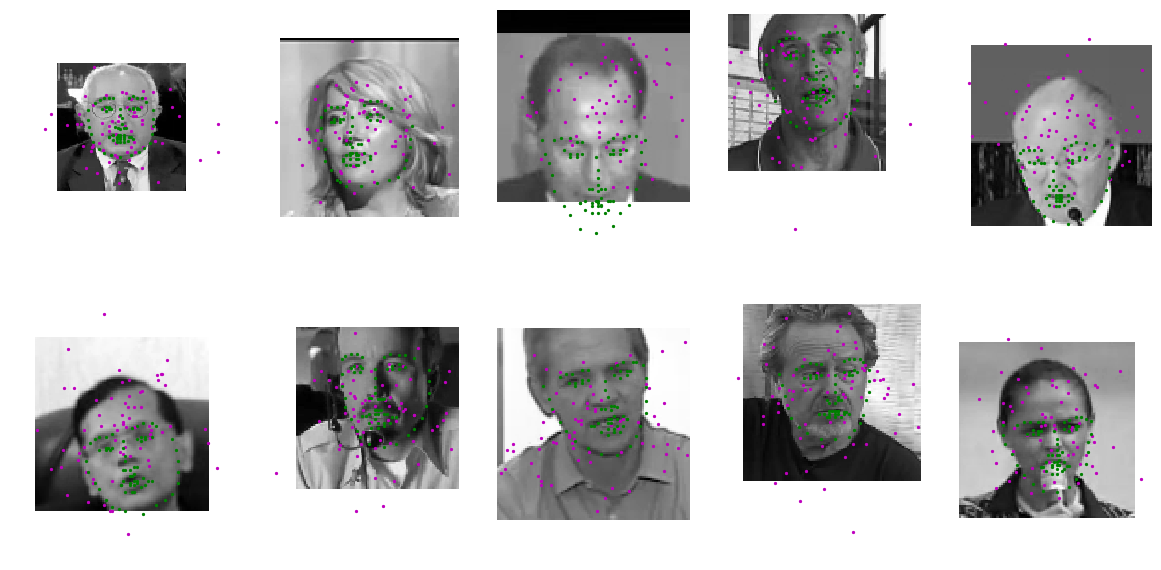

In [33]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20,10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size//5, 5, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*48.0+48
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*48.0+48
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [34]:
## Define the loss and optimization
# Using NaimishNet functions and parameters
# Note that the Adam optimizer parameters are the same as the default parameters

import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [35]:
def save_checkpoint(model, batch_losses=None, epoch_losses=None, path='checkpoint.tar'):
    """ saves the model weights and optimizers, the losses per batch"""
    torch.save({'batch_losses': batch_losses, 
                'epoch_losses': epoch_losses,
                'model': model.state_dict()
              }, path)
    
def cleanup_files(filename_prefix):
    # remove previous models
    for filename in glob.glob(filename_prefix+'*'):
        os.remove(filename)

In [36]:
def load_checkpoint(model, path):
    """ loads a checkpoint to pick up training from the last saved checkpoint"""
    checkpoint = torch.load(path)
    batch_losses = checkpoint.get('batch_losses')
    epoch_losses = checkpoint.get('epoch_losses')
    model.load_state_dict(checkpoint.get('model'))  
    
    return model, batch_losses, epoch_losses

In [37]:
def train_net(net, n_epochs, print_interval=10, save_interval=1, resume_training=False, 
              load_checkpoint_path='saved_models/best_checkpoint.tar', 
              save_checkpoint_prefix='saved_models/checkpoint', remove_old_models = False):
    batch_losses = []
    epoch_losses = []
   
    if resume_training:
        net, batch_losses, epoch_losses = load_checkpoint(net, load_checkpoint_path)
        
    # prepare the net for training
    net.train()
        
    # loop over the dataset multiple times
    for epoch in tqdm_notebook(range(len(epoch_losses)+1, n_epochs+1), desc="All Epochs"):  
        
        print_every_loss = 0.0
        epoch_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        batch_i = 1
        for data in tqdm_notebook(train_loader, desc="Epoch {}".format(epoch)):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # update loss statistics
            batch_losses.append(loss.item())
            print_every_loss += loss.item()
            epoch_loss += loss.item()
            
            # print loss statistics
            if batch_i % print_interval == 0:    # print every print_interval batches
                tqdm.write('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch, batch_i, 
                                                                        print_every_loss/print_interval))
                print_every_loss = 0.0
            
            batch_i+=1
            
        # update loss statistics
        epoch_losses.append(epoch_loss/batch_i)
        
        if (epoch) % save_interval == 0:
            if remove_old_models == True:
                cleanup_files(save_checkpoint_prefix)
            path = f'{save_checkpoint_prefix}-{epoch}.tar'
            save_checkpoint(net, batch_losses, epoch_losses, path)
            
    print('Finished Training')

In [ ]:
# train your network
# start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(net=net, n_epochs=50, resume_training=False, 
              load_checkpoint_path='saved_models/NaimishNet-30.tar',
              save_checkpoint_prefix='saved_models/NaimishNet-L1', remove_old_models = True)

HBox(children=(IntProgress(value=0, description='All Epochs: ', max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1: ', max=55), HTML(value='')))

Epoch: 1, Batch: 10, Avg. Loss: 0.11216854676604271
Epoch: 1, Batch: 20, Avg. Loss: 0.07237123623490334
Epoch: 1, Batch: 30, Avg. Loss: 0.057406213134527206
Epoch: 1, Batch: 40, Avg. Loss: 0.051090729981660844
Epoch: 1, Batch: 50, Avg. Loss: 0.044795356690883636


HBox(children=(IntProgress(value=0, description='Epoch 2: ', max=55), HTML(value='')))

Epoch: 2, Batch: 10, Avg. Loss: 0.039511730521917345
Epoch: 2, Batch: 20, Avg. Loss: 0.03150906208902597
Epoch: 2, Batch: 30, Avg. Loss: 0.029042587615549564
Epoch: 2, Batch: 40, Avg. Loss: 0.026366555690765382
Epoch: 2, Batch: 50, Avg. Loss: 0.026567259430885316


HBox(children=(IntProgress(value=0, description='Epoch 3: ', max=55), HTML(value='')))

Epoch: 3, Batch: 10, Avg. Loss: 0.023309219256043436
Epoch: 3, Batch: 20, Avg. Loss: 0.021186374500393866
Epoch: 3, Batch: 30, Avg. Loss: 0.0214806092903018
Epoch: 3, Batch: 40, Avg. Loss: 0.019843395799398422
Epoch: 3, Batch: 50, Avg. Loss: 0.01949670761823654


HBox(children=(IntProgress(value=0, description='Epoch 4: ', max=55), HTML(value='')))

Epoch: 4, Batch: 10, Avg. Loss: 0.01775729116052389
Epoch: 4, Batch: 20, Avg. Loss: 0.015597787126898766
Epoch: 4, Batch: 30, Avg. Loss: 0.01389583395794034
Epoch: 4, Batch: 40, Avg. Loss: 0.017384589556604622
Epoch: 4, Batch: 50, Avg. Loss: 0.014570352248847484


HBox(children=(IntProgress(value=0, description='Epoch 5: ', max=55), HTML(value='')))

Epoch: 5, Batch: 10, Avg. Loss: 0.01479046680033207
Epoch: 5, Batch: 20, Avg. Loss: 0.01385926716029644
Epoch: 5, Batch: 30, Avg. Loss: 0.012298517767339945
Epoch: 5, Batch: 40, Avg. Loss: 0.014108795486390591
Epoch: 5, Batch: 50, Avg. Loss: 0.014997120387852192


HBox(children=(IntProgress(value=0, description='Epoch 6: ', max=55), HTML(value='')))

Epoch: 6, Batch: 10, Avg. Loss: 0.013360526319593191
Epoch: 6, Batch: 20, Avg. Loss: 0.013134017679840326
Epoch: 6, Batch: 30, Avg. Loss: 0.011614767555147409
Epoch: 6, Batch: 40, Avg. Loss: 0.012860712502151728
Epoch: 6, Batch: 50, Avg. Loss: 0.011456056963652372


HBox(children=(IntProgress(value=0, description='Epoch 7: ', max=55), HTML(value='')))

Epoch: 7, Batch: 10, Avg. Loss: 0.011817851709201932
Epoch: 7, Batch: 20, Avg. Loss: 0.012068466003984212
Epoch: 7, Batch: 30, Avg. Loss: 0.011188168730586767
Epoch: 7, Batch: 40, Avg. Loss: 0.010865978244692088
Epoch: 7, Batch: 50, Avg. Loss: 0.011637477483600379


HBox(children=(IntProgress(value=0, description='Epoch 8: ', max=55), HTML(value='')))

Epoch: 8, Batch: 10, Avg. Loss: 0.010391287133097648
Epoch: 8, Batch: 20, Avg. Loss: 0.009137619379907846
Epoch: 8, Batch: 30, Avg. Loss: 0.010709799826145172
Epoch: 8, Batch: 40, Avg. Loss: 0.011821022257208824
Epoch: 8, Batch: 50, Avg. Loss: 0.01023395247757435


HBox(children=(IntProgress(value=0, description='Epoch 9: ', max=55), HTML(value='')))

Epoch: 9, Batch: 10, Avg. Loss: 0.010781853832304478
Epoch: 9, Batch: 20, Avg. Loss: 0.010852302005514503
Epoch: 9, Batch: 30, Avg. Loss: 0.00990849370136857
Epoch: 9, Batch: 40, Avg. Loss: 0.010496103717014194
Epoch: 9, Batch: 50, Avg. Loss: 0.012863523885607719


HBox(children=(IntProgress(value=0, description='Epoch 10: ', max=55), HTML(value='')))

Epoch: 10, Batch: 10, Avg. Loss: 0.011016597598791122
Epoch: 10, Batch: 20, Avg. Loss: 0.010512388730421662
Epoch: 10, Batch: 30, Avg. Loss: 0.010077559668570758
Epoch: 10, Batch: 40, Avg. Loss: 0.009027513954788447
Epoch: 10, Batch: 50, Avg. Loss: 0.010909760277718306


HBox(children=(IntProgress(value=0, description='Epoch 11: ', max=55), HTML(value='')))

Epoch: 11, Batch: 10, Avg. Loss: 0.010432465746998788
Epoch: 11, Batch: 20, Avg. Loss: 0.009207304334267974
Epoch: 11, Batch: 30, Avg. Loss: 0.008975498285144568
Epoch: 11, Batch: 40, Avg. Loss: 0.009796492150053382
Epoch: 11, Batch: 50, Avg. Loss: 0.009764530649408697


HBox(children=(IntProgress(value=0, description='Epoch 12: ', max=55), HTML(value='')))

Epoch: 12, Batch: 10, Avg. Loss: 0.010685802018269897
Epoch: 12, Batch: 20, Avg. Loss: 0.009471649304032326
Epoch: 12, Batch: 30, Avg. Loss: 0.012726164143532514
Epoch: 12, Batch: 40, Avg. Loss: 0.008583155041560531
Epoch: 12, Batch: 50, Avg. Loss: 0.009818271687254309


HBox(children=(IntProgress(value=0, description='Epoch 13: ', max=55), HTML(value='')))

Epoch: 13, Batch: 10, Avg. Loss: 0.011917773028835654
Epoch: 13, Batch: 20, Avg. Loss: 0.011795940296724438
Epoch: 13, Batch: 30, Avg. Loss: 0.009716338850557804
Epoch: 13, Batch: 40, Avg. Loss: 0.010895638028159738
Epoch: 13, Batch: 50, Avg. Loss: 0.009033738216385246


HBox(children=(IntProgress(value=0, description='Epoch 14: ', max=55), HTML(value='')))

Epoch: 14, Batch: 10, Avg. Loss: 0.011348322173580528
Epoch: 14, Batch: 20, Avg. Loss: 0.00941496966406703
Epoch: 14, Batch: 30, Avg. Loss: 0.010977955907583237
Epoch: 14, Batch: 40, Avg. Loss: 0.010201658494770527
Epoch: 14, Batch: 50, Avg. Loss: 0.009770413488149643


HBox(children=(IntProgress(value=0, description='Epoch 15: ', max=55), HTML(value='')))

Epoch: 15, Batch: 10, Avg. Loss: 0.010899924254044891
Epoch: 15, Batch: 20, Avg. Loss: 0.010266088554635644
Epoch: 15, Batch: 30, Avg. Loss: 0.008838730491697788
Epoch: 15, Batch: 40, Avg. Loss: 0.008733139466494321
Epoch: 15, Batch: 50, Avg. Loss: 0.007865070784464478


HBox(children=(IntProgress(value=0, description='Epoch 16: ', max=55), HTML(value='')))

Epoch: 16, Batch: 10, Avg. Loss: 0.007987020537257195
Epoch: 16, Batch: 20, Avg. Loss: 0.009056580811738968
Epoch: 16, Batch: 30, Avg. Loss: 0.01098701599985361
Epoch: 16, Batch: 40, Avg. Loss: 0.008499098615720868
Epoch: 16, Batch: 50, Avg. Loss: 0.008880515536293387


HBox(children=(IntProgress(value=0, description='Epoch 17: ', max=55), HTML(value='')))

Epoch: 17, Batch: 10, Avg. Loss: 0.009035127330571413
Epoch: 17, Batch: 20, Avg. Loss: 0.011259315721690654
Epoch: 17, Batch: 30, Avg. Loss: 0.008673814637586475
Epoch: 17, Batch: 40, Avg. Loss: 0.008059974061325192
Epoch: 17, Batch: 50, Avg. Loss: 0.0075010226108133795


HBox(children=(IntProgress(value=0, description='Epoch 18: ', max=55), HTML(value='')))

Epoch: 18, Batch: 10, Avg. Loss: 0.009458095580339432
Epoch: 18, Batch: 20, Avg. Loss: 0.007881988771259785
Epoch: 18, Batch: 30, Avg. Loss: 0.009305866109207273
Epoch: 18, Batch: 40, Avg. Loss: 0.009343296382576227
Epoch: 18, Batch: 50, Avg. Loss: 0.007813040493056178


HBox(children=(IntProgress(value=0, description='Epoch 19: ', max=55), HTML(value='')))

Epoch: 19, Batch: 10, Avg. Loss: 0.00937365903519094
Epoch: 19, Batch: 20, Avg. Loss: 0.006891357898712158
Epoch: 19, Batch: 30, Avg. Loss: 0.008331999275833368
Epoch: 19, Batch: 40, Avg. Loss: 0.008430728642269968
Epoch: 19, Batch: 50, Avg. Loss: 0.009206302929669619


HBox(children=(IntProgress(value=0, description='Epoch 20: ', max=55), HTML(value='')))

Epoch: 20, Batch: 10, Avg. Loss: 0.008012075489386917
Epoch: 20, Batch: 20, Avg. Loss: 0.008237147703766823
Epoch: 20, Batch: 30, Avg. Loss: 0.009344989154487848
Epoch: 20, Batch: 40, Avg. Loss: 0.01037124553695321
Epoch: 20, Batch: 50, Avg. Loss: 0.007237956440076232


HBox(children=(IntProgress(value=0, description='Epoch 21: ', max=55), HTML(value='')))

Epoch: 21, Batch: 10, Avg. Loss: 0.007811872195452452
Epoch: 21, Batch: 20, Avg. Loss: 0.007816967694088817
Epoch: 21, Batch: 30, Avg. Loss: 0.007702156156301499
Epoch: 21, Batch: 40, Avg. Loss: 0.009268291760236025
Epoch: 21, Batch: 50, Avg. Loss: 0.008199984300881624


HBox(children=(IntProgress(value=0, description='Epoch 22: ', max=55), HTML(value='')))

Epoch: 22, Batch: 10, Avg. Loss: 0.009883730206638575
Epoch: 22, Batch: 20, Avg. Loss: 0.00996336187236011
Epoch: 22, Batch: 30, Avg. Loss: 0.008149516582489014
Epoch: 22, Batch: 40, Avg. Loss: 0.007908210065215826
Epoch: 22, Batch: 50, Avg. Loss: 0.008924199407920242


HBox(children=(IntProgress(value=0, description='Epoch 23: ', max=55), HTML(value='')))

Epoch: 23, Batch: 10, Avg. Loss: 0.007884250767529011
Epoch: 23, Batch: 20, Avg. Loss: 0.008409596839919686
Epoch: 23, Batch: 30, Avg. Loss: 0.010135226976126432
Epoch: 23, Batch: 40, Avg. Loss: 0.007468970492482185
Epoch: 23, Batch: 50, Avg. Loss: 0.008602377539500595


HBox(children=(IntProgress(value=0, description='Epoch 24: ', max=55), HTML(value='')))

Epoch: 24, Batch: 10, Avg. Loss: 0.007710182340815663
Epoch: 24, Batch: 20, Avg. Loss: 0.007223870418965816
Epoch: 24, Batch: 30, Avg. Loss: 0.008995123207569122
Epoch: 24, Batch: 40, Avg. Loss: 0.0065839685499668125
Epoch: 24, Batch: 50, Avg. Loss: 0.0088409339543432


HBox(children=(IntProgress(value=0, description='Epoch 25: ', max=55), HTML(value='')))

Epoch: 25, Batch: 10, Avg. Loss: 0.010368795040994883
Epoch: 25, Batch: 20, Avg. Loss: 0.007060514623299241
Epoch: 25, Batch: 30, Avg. Loss: 0.007747484231367707
Epoch: 25, Batch: 40, Avg. Loss: 0.006655109021812678
Epoch: 25, Batch: 50, Avg. Loss: 0.00956552792340517


HBox(children=(IntProgress(value=0, description='Epoch 26: ', max=55), HTML(value='')))

Epoch: 26, Batch: 10, Avg. Loss: 0.009983655670657754
Epoch: 26, Batch: 20, Avg. Loss: 0.007545034540817142
Epoch: 26, Batch: 30, Avg. Loss: 0.006917523220181465
Epoch: 26, Batch: 40, Avg. Loss: 0.007835904927924275
Epoch: 26, Batch: 50, Avg. Loss: 0.006472650356590748


HBox(children=(IntProgress(value=0, description='Epoch 27: ', max=55), HTML(value='')))

Epoch: 27, Batch: 10, Avg. Loss: 0.008037055050954223
Epoch: 27, Batch: 20, Avg. Loss: 0.006651114672422409
Epoch: 27, Batch: 30, Avg. Loss: 0.007139745075255633
Epoch: 27, Batch: 40, Avg. Loss: 0.011621097289025783
Epoch: 27, Batch: 50, Avg. Loss: 0.006191339995712042


HBox(children=(IntProgress(value=0, description='Epoch 28: ', max=55), HTML(value='')))

Epoch: 28, Batch: 10, Avg. Loss: 0.007939359452575446
Epoch: 28, Batch: 20, Avg. Loss: 0.007426181668415665
Epoch: 28, Batch: 30, Avg. Loss: 0.007818198250606655
Epoch: 28, Batch: 40, Avg. Loss: 0.007180237863212824
Epoch: 28, Batch: 50, Avg. Loss: 0.008072156086564064


HBox(children=(IntProgress(value=0, description='Epoch 29: ', max=55), HTML(value='')))

Epoch: 29, Batch: 10, Avg. Loss: 0.009412932442501187
Epoch: 29, Batch: 20, Avg. Loss: 0.00878729745745659
Epoch: 29, Batch: 30, Avg. Loss: 0.008084686240181327
Epoch: 29, Batch: 40, Avg. Loss: 0.00652115922421217
Epoch: 29, Batch: 50, Avg. Loss: 0.005459522362798452


HBox(children=(IntProgress(value=0, description='Epoch 30: ', max=55), HTML(value='')))

Epoch: 30, Batch: 10, Avg. Loss: 0.007089281687512994
Epoch: 30, Batch: 20, Avg. Loss: 0.00725094904191792
Epoch: 30, Batch: 30, Avg. Loss: 0.006650153221562505
Epoch: 30, Batch: 40, Avg. Loss: 0.00616207430139184
Epoch: 30, Batch: 50, Avg. Loss: 0.007234650431200862


HBox(children=(IntProgress(value=0, description='Epoch 31: ', max=55), HTML(value='')))

Epoch: 31, Batch: 10, Avg. Loss: 0.007328552659600973
Epoch: 31, Batch: 20, Avg. Loss: 0.007089562201872468
Epoch: 31, Batch: 30, Avg. Loss: 0.006775908265262842
Epoch: 31, Batch: 40, Avg. Loss: 0.007423039199784398
Epoch: 31, Batch: 50, Avg. Loss: 0.007104586670175194


HBox(children=(IntProgress(value=0, description='Epoch 32: ', max=55), HTML(value='')))

Epoch: 32, Batch: 10, Avg. Loss: 0.00771023235283792
Epoch: 32, Batch: 20, Avg. Loss: 0.005966937262564897
Epoch: 32, Batch: 30, Avg. Loss: 0.006085556233301759
Epoch: 32, Batch: 40, Avg. Loss: 0.006323360558599234
Epoch: 32, Batch: 50, Avg. Loss: 0.01069242381490767


HBox(children=(IntProgress(value=0, description='Epoch 33: ', max=55), HTML(value='')))

Epoch: 33, Batch: 10, Avg. Loss: 0.007026338437572122
Epoch: 33, Batch: 20, Avg. Loss: 0.0058311271015554665
Epoch: 33, Batch: 30, Avg. Loss: 0.007380260620266199
Epoch: 33, Batch: 40, Avg. Loss: 0.007242241641506553
Epoch: 33, Batch: 50, Avg. Loss: 0.006734103383496404


HBox(children=(IntProgress(value=0, description='Epoch 34: ', max=55), HTML(value='')))

Epoch: 34, Batch: 10, Avg. Loss: 0.007063555298373103
Epoch: 34, Batch: 20, Avg. Loss: 0.007548728724941611
Epoch: 34, Batch: 30, Avg. Loss: 0.0063146701082587246
Epoch: 34, Batch: 40, Avg. Loss: 0.006269145710393787
Epoch: 34, Batch: 50, Avg. Loss: 0.009279040200635792


HBox(children=(IntProgress(value=0, description='Epoch 35: ', max=55), HTML(value='')))

Epoch: 35, Batch: 10, Avg. Loss: 0.009063918143510818
Epoch: 35, Batch: 20, Avg. Loss: 0.006885327026247978
Epoch: 35, Batch: 30, Avg. Loss: 0.008425583085045218
Epoch: 35, Batch: 40, Avg. Loss: 0.008101521851494908
Epoch: 35, Batch: 50, Avg. Loss: 0.006155552668496966


HBox(children=(IntProgress(value=0, description='Epoch 36: ', max=55), HTML(value='')))

Epoch: 36, Batch: 10, Avg. Loss: 0.00786937791854143
Epoch: 36, Batch: 20, Avg. Loss: 0.006126315006986261
Epoch: 36, Batch: 30, Avg. Loss: 0.007056671241298318
Epoch: 36, Batch: 40, Avg. Loss: 0.00792825068347156
Epoch: 36, Batch: 50, Avg. Loss: 0.006430818233639002


HBox(children=(IntProgress(value=0, description='Epoch 37: ', max=55), HTML(value='')))

Epoch: 37, Batch: 10, Avg. Loss: 0.0073501270730048415
Epoch: 37, Batch: 20, Avg. Loss: 0.005898791458457708
Epoch: 37, Batch: 30, Avg. Loss: 0.006225435761734843
Epoch: 37, Batch: 40, Avg. Loss: 0.008096473012119531
Epoch: 37, Batch: 50, Avg. Loss: 0.006874097930267453


HBox(children=(IntProgress(value=0, description='Epoch 38: ', max=55), HTML(value='')))

Epoch: 38, Batch: 10, Avg. Loss: 0.007496591983363032
Epoch: 38, Batch: 20, Avg. Loss: 0.006682311883196235
Epoch: 38, Batch: 30, Avg. Loss: 0.00795164592564106
Epoch: 38, Batch: 40, Avg. Loss: 0.007139417668804526
Epoch: 38, Batch: 50, Avg. Loss: 0.007034366857260466


HBox(children=(IntProgress(value=0, description='Epoch 39: ', max=55), HTML(value='')))

Epoch: 39, Batch: 10, Avg. Loss: 0.007335549499839544
Epoch: 39, Batch: 20, Avg. Loss: 0.006868780683726072
Epoch: 39, Batch: 30, Avg. Loss: 0.006433030357584357
Epoch: 39, Batch: 40, Avg. Loss: 0.006005232594907284
Epoch: 39, Batch: 50, Avg. Loss: 0.0061654670163989065


HBox(children=(IntProgress(value=0, description='Epoch 40: ', max=55), HTML(value='')))

Epoch: 40, Batch: 10, Avg. Loss: 0.005827217688784003
Epoch: 40, Batch: 20, Avg. Loss: 0.006340488884598016
Epoch: 40, Batch: 30, Avg. Loss: 0.006172394147142768
Epoch: 40, Batch: 40, Avg. Loss: 0.005335494875907898
Epoch: 40, Batch: 50, Avg. Loss: 0.007615481223911047


HBox(children=(IntProgress(value=0, description='Epoch 41: ', max=55), HTML(value='')))

Epoch: 41, Batch: 10, Avg. Loss: 0.007018261682242155
Epoch: 41, Batch: 20, Avg. Loss: 0.009052568208426237
Epoch: 41, Batch: 30, Avg. Loss: 0.006259726360440254
Epoch: 41, Batch: 40, Avg. Loss: 0.008745836233720184
Epoch: 41, Batch: 50, Avg. Loss: 0.006339394859969616


HBox(children=(IntProgress(value=0, description='Epoch 42: ', max=55), HTML(value='')))

Epoch: 42, Batch: 10, Avg. Loss: 0.008366466825827956
Epoch: 42, Batch: 20, Avg. Loss: 0.009084997326135635
Epoch: 42, Batch: 30, Avg. Loss: 0.00850339033640921
Epoch: 42, Batch: 40, Avg. Loss: 0.007083174353465438
Epoch: 42, Batch: 50, Avg. Loss: 0.007758094603195787


HBox(children=(IntProgress(value=0, description='Epoch 43: ', max=55), HTML(value='')))

Epoch: 43, Batch: 10, Avg. Loss: 0.009641144005581737
Epoch: 43, Batch: 20, Avg. Loss: 0.005927516566589475
Epoch: 43, Batch: 30, Avg. Loss: 0.006234526121988893
Epoch: 43, Batch: 40, Avg. Loss: 0.006170521769672632
Epoch: 43, Batch: 50, Avg. Loss: 0.005476240627467632


HBox(children=(IntProgress(value=0, description='Epoch 44: ', max=55), HTML(value='')))

Epoch: 44, Batch: 10, Avg. Loss: 0.008349549723789096
Epoch: 44, Batch: 20, Avg. Loss: 0.0068797860760241745
Epoch: 44, Batch: 30, Avg. Loss: 0.007127074431627989
Epoch: 44, Batch: 40, Avg. Loss: 0.006436285749077797
Epoch: 44, Batch: 50, Avg. Loss: 0.007042196486145258


HBox(children=(IntProgress(value=0, description='Epoch 45: ', max=55), HTML(value='')))

Epoch: 45, Batch: 10, Avg. Loss: 0.006620698980987072
Epoch: 45, Batch: 20, Avg. Loss: 0.005881398497149348


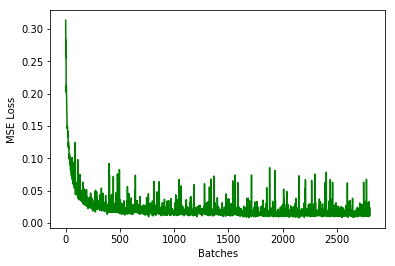

In [17]:
model = NaimishNet()
net, batch_losses, epoch_losses = load_checkpoint(model, 'saved_models/NaimishNet-51.tar')

plt.xlabel("Batches")
plt.ylabel("MSE Loss")
plt.plot(batch_losses, "g-")

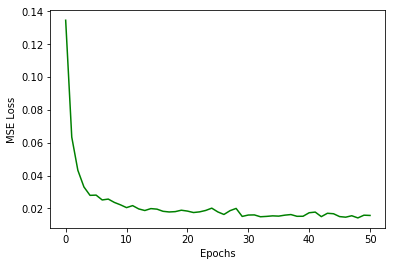

In [18]:
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.plot(epoch_losses, "g-")

In [20]:
epoch_losses

[0.13463991773980005,
 0.06342564170647945,
 0.04321559578446405,
 0.03303955515314426,
 0.0279170448027019,
 0.028060012463746325,
 0.025112962566449175,
 0.025639962970412204,
 0.02360450102215899,
 0.022144101094454527,
 0.02044059567353023,
 0.021654476910563453,
 0.019644897248196815,
 0.01867695031355002,
 0.019840095824162875,
 0.01950794320353972,
 0.018192586322714175,
 0.017789688177539835,
 0.017995311845360056,
 0.01885434173579727,
 0.018328867120934383,
 0.01744507876823523,
 0.01784908468835056,
 0.01871466783008405,
 0.020112798831957792,
 0.017813469366436557,
 0.016265627379263087,
 0.0185797860945708,
 0.01995297577897353,
 0.015073929613988315,
 0.015917024325712452,
 0.015992861740025028,
 0.01487085793633014,
 0.01509371298431818,
 0.015416193304450385,
 0.015253278726179684,
 0.015845531963610222,
 0.01620925241149962,
 0.015144022214891655,
 0.015179410593451135,
 0.017317666905000806,
 0.01770872263503926,
 0.014946557498270912,
 0.016988899309321175,
 0.016710

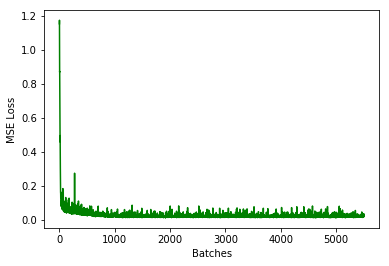

In [22]:
model = LeNet()

checkpoint = torch.load('saved_models/Best-LeNet-100.tar')
losses = checkpoint.get('losses')
model.load_state_dict(checkpoint.get('model')) 

plt.xlabel("Batches")
plt.ylabel("MSE Loss")
plt.plot(losses, "g-")

In [ ]:
len(losses)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


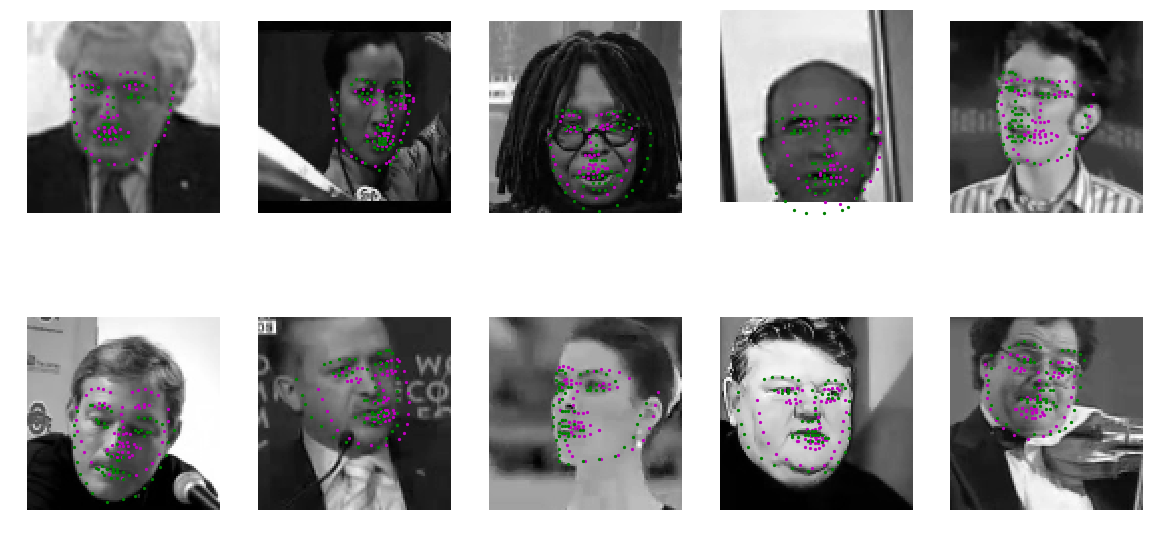

In [22]:
## visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I tried to replicate the architecture in the [Facial Key Points Detection using Deep
Convolutional Neural Network - NaimishNet](https://arxiv.org/pdf/1710.00977.pdf) paper.  For their model they used an Adam optimizer with the default parameters.  The Adam optimizer uses an adaptive learning rate based on the moments of the gradients.  It is a very popular algorithm and a good initial for any deep learning network.  
The NaimishNet paper computed loss using the Mean Square Error (MSE) function.  This is a good way of measuring the difference between the predicted key points and the ground truth points.  The MSE function is the what I ended up using.  It seems to work well.  Another loss function that is worth investigating is the Mean Average Error (MAE).  This function also measures the distance between the predicted points and ground truth points but does not penalize outliers as much.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Once again, I tried to emulate the NaimishNet paper and largely replicated its architecture of four convolutional layers and three dense layers.  Following the suggestion in this notebook, I modified the input layer to 1 x 224 x 224 in size.  This input size seems to be the convention for many effective networks such as AlexNet and VGG-16 and is the result of cropping a 256 x 256 RGB image that is commonly found in the ImageNet dataset.  Then I used the the NaimishNet kernel sizes and padding to make four convolutional layers.  The final output layer was modified to have 136 outputs, corresponding the number of keypoints per image.  I'll refer to this model as LargeNaimishNet.  It took about 20 minutes per epoch to train which I decided was much too long, especially since I was still in a prototyping debugging phase creating a training algorithm.  
I then decided to LeNet architecture which only has two convolutional layers and an input image size of 1 x 96 x 96.  This ran very quickly (about 1 minute per epoch) and helped me debug the train_net() training function and other helper functions that I made to save and load checkpoints.  While using this I found that the Loss bottomed out at a value of around 0.025 and didn't seem to improve, even after 100 epochs.  I decided that this network wasn't deep enough.  
So I revisted the NaimishNet but with the smaller input size of 1 x 96 x 96.  It has several dropout layers to guard against overfitting.  I added some batch normalization which seems to help any deep learning model.  It takes about 2.5 minutes to train an epoch.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Because of an unreliable internet connection, I have gotten into the habit of frequently saving models during training.  For this project I saved the model and its losses after every epoch and generally ran 10 epochs at a time which seemed a good interval to check up on the performance and get rid of any models that didn't need to be saved.  Thus it was easy for me to keep running epochs on a model until I felt I got satisfactory performance and I didn't need to guess or try to optimize a good number of epochs.  
For batch size, I generally try to go for the largest number that will run on a machine without throwing errors.  I found this to be about 64 samples.  This was the batch size I used for training.  For testing, I stuck with 10 since that seemed like a good number of images for visual inspection.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.15764779 -0.16136885  0.06125105]
 [ 0.03763986 -0.09246992 -0.05785117]
 [ 0.28435728 -0.11062445  0.16611883]]
(3, 3)


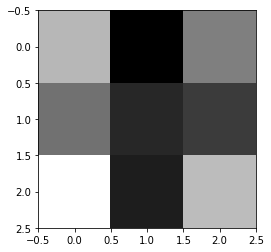

In [23]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!